In [150]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)
sns.set_style('white')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
from mouselab import *
from bayes_q import *
from gymrats.core import Agent
from exact import solve
from skopt import gp_minimize
from skopt.space import Real,Space

In [152]:
cost_range = [0,0.3]
branch_range = [2,4]
height_range = [2,4]
reward_alpha = 1

In [124]:
def get_optimal_return(env):
    q, v, pi, info = solve(env)
    return v(env.init)

def sample_env():
    cost = np.random.uniform(*cost_range)
    branch = np.random.randint(*branch_range)
    height = np.random.randint(*height_range)
    R = Categorical([-1, 0, 1],np.random.dirichlet(np.ones(3)*reward_alpha))
    return MouselabEnv(branch, height, reward=R, cost=cost)

In [125]:
def create_training_df(env,N,prior_params=None):
    policy = BayesianQLearner(5,prior_params=prior_params)
    Q = policy.Q
    agent = Agent(env, policy)
    return pd.DataFrame(agent.run_many(N,pbar=False))

def meta_training_objective_single(x):
    N=20
    df = create_training_df(sample_env(),N,prior_params=x)
    return np.mean(df.return_.values)

def meta_training_objective(x):
    meta_training_objective.counter += 1
    y = np.mean([meta_training_objective_single(x) for _ in range(25)])
    print(meta_training_objective.counter,y,np.round(x,2))
    return y

def train_meta_agent(N):
    x0 = list(np.r_[np.zeros(4) , 1, np.ones(4)*0.1, 100, 10,1])
    dimensions = [Real(0,1)]*5 + [Real(0.1,100)]*5 + [Real(0.1,20)] + [Real(0.1,10)]
    return gp_minimize(lambda x: -meta_training_objective(x),x0=x0,dimensions=dimensions,n_calls=N)

In [137]:
def plot_weights(policy):
    W = np.stack(policy.weight_log)
    plt.plot(W)

In [126]:
meta_training_objective.counter = 0
res = train_meta_agent(100)

1 0.20952913557922404 [  0.    0.    0.    0.    1.    0.1   0.1   0.1   0.1 100.   10.    1. ]
2 0.41522011292583355 [ 0.8   0.61  0.5   0.57  0.32  6.59 21.98  7.22 92.55 30.33 14.47  5.77]
3 -0.007141340485076899 [3.200e-01 3.000e-02 4.300e-01 9.000e-01 5.600e-01 7.549e+01 6.340e+01 1.268e+01 5.163e+01 8.458e+01 1.008e+01 1.560e+00]
4 0.6976222393832008 [ 0.47  0.6   0.93  0.4   0.68 72.29 22.97 24.36 29.65 28.61  1.11  0.34]
5 0.1634859379691211 [6.000e-01 6.000e-02 4.400e-01 7.700e-01 9.800e-01 6.357e+01 7.757e+01 5.819e+01 7.214e+01 1.672e+01 5.420e+00 1.960e+00]
6 0.42708789844330497 [2.700e-01 9.100e-01 8.200e-01 5.000e-02 3.600e-01 6.120e+00 3.540e+00 8.600e+00 7.136e+01 1.867e+01 1.263e+01 5.710e+00]
7 0.8548460488476186 [ 0.46  0.74  0.9   0.66  0.27 79.28 67.4  88.7  10.5  18.1  14.54  9.5 ]
8 0.04071669441975858 [ 0.7   0.6   0.33  0.8   0.85 73.58 95.83  8.67 45.63 96.51 16.06  8.18]
9 0.4928783777666008 [ 0.24  0.68  0.26  0.24  0.49 83.47 52.19  5.18  1.93 48.05  0.32  

73 0.6380799686114699 [ 0.38  0.59  0.3   0.75  0.87  6.81 93.25 68.12 47.61 12.85 15.69  9.17]
74 0.1724154256980131 [ 0.21  0.22  0.96  0.84  0.97 43.66  2.04 98.96  9.89 11.8   4.45  8.76]
75 0.2692198736063532 [ 0.14  0.99  0.09  0.72  0.41  7.96 52.15 67.14  0.1   6.51 13.51  3.69]
76 0.44528314505639766 [ 0.    0.83  0.41  0.2   0.32  2.65 48.02 65.95 97.34 82.54  4.88  5.19]
77 0.3389518197585493 [2.800e-01 5.300e-01 3.300e-01 2.000e-02 6.000e-02 4.523e+01 2.241e+01 8.518e+01 9.914e+01 2.294e+01 1.031e+01 7.300e-01]
78 0.3994477084237559 [ 0.43  0.32  0.79  0.98  0.52  0.52 56.43 74.56 98.48 88.69 15.76  5.85]
79 0.5313801753107598 [  0.63   0.24   0.27   0.     0.59  13.15  82.1   77.71 100.     8.95   2.95   4.51]
80 0.2471443643790944 [ 0.23  0.3   0.24  0.75  0.19 43.23 66.5   3.44  1.27 27.8  18.79 10.  ]
81 0.2864346242357726 [6.600e-01 4.500e-01 3.000e-01 4.000e-02 8.800e-01 1.296e+01 4.660e+00 1.280e+00 1.000e+02 9.036e+01 1.629e+01 2.590e+00]
82 0.784226493103262 [ 0.95

In [127]:
res.x

[0.38622739257055405,
 0.6445798361152787,
 0.23677999811258774,
 0.661553625732236,
 0.17255836911580777,
 6.94933612877879,
 32.44529374265896,
 68.74042193284149,
 0.9252599073288498,
 13.383395567049416,
 11.372075806774978,
 9.209816294959673]

In [136]:
num_steps = 20
num_replications = 1000
envs = [sample_env() for _ in range(num_replications)]
dfs = [create_training_df(env,num_steps) for env in envs]
dfs_meta = [create_training_df(env,num_steps,prior_params=res.x) for env in envs]
#optimal_return = [get_optimal_return(env) for env in envs]

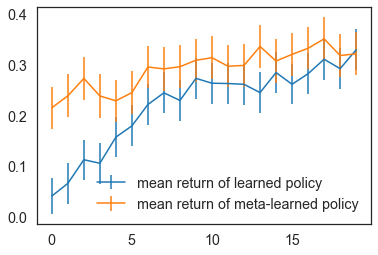

In [137]:
returns = np.array([df.return_ for df in dfs])
returns_meta = np.array([df.return_ for df in dfs_meta])
plt.errorbar(x=np.arange(returns.shape[1]),y=np.mean(returns,axis=0),
             yerr=np.std(returns,axis=0)/np.sqrt(returns.shape[0]),label='mean return of learned policy')
plt.errorbar(x=np.arange(returns_meta.shape[1]),y=np.mean(returns_meta,axis=0),
             yerr=np.std(returns_meta,axis=0)/np.sqrt(returns_meta.shape[0]),label='mean return of meta-learned policy')
#plt.errorbar(np.mean(returns_meta,axis=0),'.-',label='mean return of meta-learned policy')
#plt.plot(pd.DataFrame(np.mean(returns,axis=0)).rolling(10).mean(),'.-',label='mean return of learned policy')
#plt.axhline(np.mean(optimal_return),color='black',linestyle='dashed',label='return of optimal policy')
plt.legend(frameon=False)

plt.show()

#plt.show()
#df.n_steps.rolling(1).mean().plot()
#plt.show()

In [145]:
np.savetxt('returns_notmeta.txt',returns)
np.savetxt('returns_meta.txt',returns_meta)

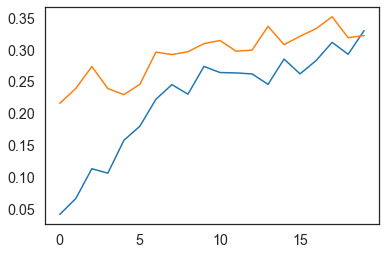

In [149]:
x = np.loadtxt('returns_notmeta.txt')
y = np.loadtxt('returns_meta.txt')
plt.plot(np.mean(x,axis=0))
plt.plot(np.mean(y,axis=0))